# Application bancaire d'aide à l'octroi de prêt
Auteur: Pierre-Yves Prodhomme

## Objectif
Afin de pouvoir répondre à leur client de la manière la plus équitable/transparente possible, les instituts bancaires font apppel à du machine learning pour les aider dans l'octroi de prêt à leur client.
Ce notebook vise à décrire la méthode globale pour réaliser une application d'aide à l'octroi de prêt bancaire. 
*Ce projet est un POC qui n'inclut pas la gestion de la sécurité quand au transfert des données au travers du réseau.*
La méthode comprend différentes étapes qui correspondent au plan de cet article:
- collecte et préparation des données
- Sélection du modèle (benchmark)
    - Préprocess : réduction du dataset 
    - Stratégie et Préparation
    - Score et classement
- Rééquilibrage et augmentation des données
- déploiement de l'application
- Perspectives

## Résumé
Afin de limiter le nombre de données lors de l'évaluation des modèles, une  réduction du dataset (sub-dataset = 20% dataset initial) tout en conservant une distribution semblable au dataset de départ a été réalisée.
Les modèles sélectionnés ont ensuite été testés sur un datataset un peu plus large (40%) et un équilibrage des donnéesa a été expérimenté tout en continuant à optimiser les hyperparamètres du modèle choisi.
Finalement le modèle a été optimisé sur le dataset global légèrement modifié pour le rééquilibrage.
Enfin une application est mise en place dans le cloud, elle comprend une API déployée sur pythonanywhere.com avec flask et une UI sur streamlit.com.  
L'utilisateur (employé de banque) peut évaluer le risque de défaillance d'un candidat au prêt et connaître les raisons majeures (features importances) qui poussent à faire cette estimation.

## Collecte et Préparation des données
Le dataset de départ est récupéré sur [kaggle](https://www.kaggle.com/competitions/home-credit-default-risk).
Dans un premier temps le feature engineering est réalisé à partir du [notebook](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script ) de AGUIAR.

dataset relationship       | Data_engineering summary
:-------------------------:|:-------------------------:
![dataset_relationship](images/dataset_relationship.jpg) | ![data_engineering](images/data_engineering_reduced.jpg)

Le dataset de départ pour le benchmark des modèles contient donc un peu plus de 307 k.individus ayant 766 features.

## Sélection  du modèle
### Préprocess: réduction du dataset
Le dataset étant relativement large, afin d'accélérer les calculs nous constituons un dataset de plus petite dimension qui sera représentatif du dataset de départ. Chaque classe (classe 0 et classe 1) est traitée séparément.  
Le nombre de features est légèrement réduit via une ACP (les composantes principales représente 99% de la variance expliquée).  
Ensuite un clustering est réalisé toujours sur chaque classe séparément: chaque classe est réparti en 100 clusters.  
Ainsi il y a n_i échnatillons par cluster, on autorise un seul cluster avec moins de 10 individus.  
Ensuite pour constituer un sous-dataset, on pioche aléatoirement un ratio d'individus dans chaque cluster.  
Cela permet de constituer un dataset avec une répartition proche du dataset de départ.

In [1]:
import sys
sys.path.append('../functions/')
import projet7_functions as p7f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
# print(os.getcwd())

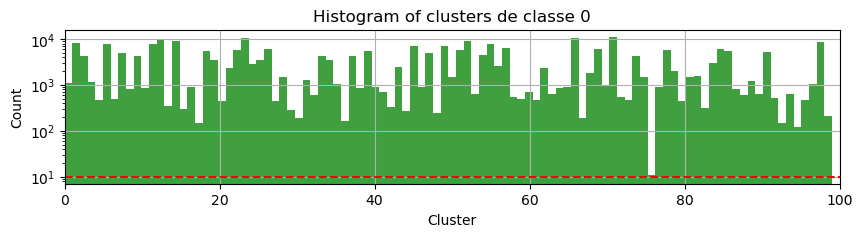

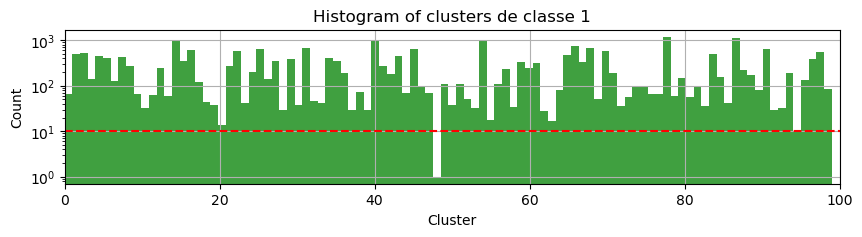

In [2]:
read_csv = True
if read_csv :
    with p7f.timer(""):  #"lecture du dataset"
        df_full = pd.read_csv('../Notebook/home-credit-default-risk/feature_engineered_data.csv')

# df_full = pd.read_csv('../Notebook/home-credit-default-risk/feature_engineered_data.csv')
df_full.shape
p7f.reduce_samples(df=df_full)

### Stratégie et Préparation
Afin d'éviter de travailler sur de trop nombreuses variables en même temps, 
Le traitement de variables déséquilibrés est reporté à une phase ultérieure, lorsque un ou deux modèles se dégageront du lot.
La prise en compte d'un nombre importants de variables nécessiterait de multiplier les calculs, cela serait beaucoup trop chronophage.

**Réduction de dimension**  
D'autre part nous testons quelques réduction de dimension sur les features. D'un point de vue métier ce n'est pas pertinent, mais cela permet de vérifier si une réduction de dimension permettrait d'améliorer les scores obtenus. 

**Preprocess and Gridsearch**  
Un undesampling de 0.5 semble être raisonnable pour débuter le benchmark.  
Ainsi pour commencer notre benchmark des différents modèles, nous partons sur un pipeline:    
Pipeline(UnderSampling(0.5), StandardScaler(), Model) 

Les modèles avec les hyperparamètres testés sont listés ci-dessous dans le tableau.

<!-- Librairies  | sklearn |sklearn | sklearn | sklearn      | XGBoost | sklearn | LightGBM |  sklearn    | TF     -->  
<!--:-------------:|:-------:|:------:|:-------:|:------------:|:-------:|:-------:|:--------:|:-----------:|:------: -->
<!--**Modèles**    |  SVC    |  NBG   | LogReg  | RandomForest | XGBoost | HistGBM | LightGBM |    MLP      | MLP     -->

**Modèles**    |  Librairies | Hyperparamètres 
:-------------:|:-----------:|:----------:
Dummy          |  sklearn    |
SVC            |  sklearn    | {'C': [0.1, 1, 10], 'class_weight': ['balanced', None], 'gamma':[0.1, 1, 10] }
NaiveBayesian  |  sklearn    | Gaussian
kNN            |  sklearn    | {'n_neighbors': [5, 10, 20], 'leaf_size': [10, 30], 'weights':["uniform", "distance"] }
LogReg         |  sklearn    | {'penalty': ["l2", "none"], 'class_weight': ['balanced', None], 'max_iter':[100, 500] }
RandomForest   |  sklearn    | {'max_depth': [5, 10], "min_impurity_decrease": [0.01, 0.001],            "min_samples_leaf":[10, 20], "n_estimators":[100, 500], “class_weight":["balanced", None]}
XGBoost        |  XGBoost    | {'max_depth': [3, 6], 'n_estimators': [500, 1000], "learning_rate": [0.02, 0.005], "min_child_weight":[1, 10]} 
HistGBM        |  sklearn    | {'max_depth': [3, 6], 'max_iter': [500, 1000], "learning_rate": [0.1, 0.05], "min_samples_leaf":[20, 50]} 
LightGBM       |  LightGBM   | {'m__max_depth': [3, 6], "m__learning_rate": [0.1, 0.05], "m__min_child_samples":[20, 50]}
MLP (3 layers) |  sklearn    | {"dense_size" : [16, 12], "activation_hidden_layers" : ["tanh"], "class_weight": [None, "balanced"],  "m__dropout" : [0.5, 0.25, 0]
MLP (3 layers) |  TensorFlow | {"dense_size" : [16, 12], "activation_hidden_layers" : ["tanh"], "class_weight": [None, "balanced"],  "m__dropout" : [0.5, 0.25, 0]


### Score et classement
Le score utilisé pour le benchmark est roc_auc.  
**Avantage**: il permet d'estimer d'une manière globale la performance du modèle en précision ou en recall.  
**Inconvénient** : l'estimation est grossière et ne permet pas d'affiner le modèle pour un objectif précis.
Pour cela il vaut mieux utiliser le $F_\beta score$.  

Le graphe ci-dessous illustre la stabilité du modèle XGBOOST par rapport au jeu de données (axe des abscisses 10 split CV).  
Chaque courbe correspond à un jeu d'hyperparamètres.  
On affiche le score AUC obtenu par le set de test pour chaque split.
Sur le graphe, les 5 meilleurs score moyen sont affichés.  
Les scores moyens et les jeux de paramètres sont affichés dans le tableau suivant.

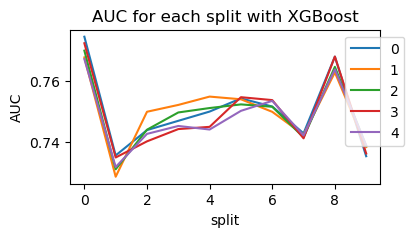

In [3]:
ModelList = p7f.get_list(file_path="../Notebook/ModelResults.pkl") 
split_results_df = pd.merge(ModelList[2][3], ModelList[2][4].rank_test_score, 
                    left_index=True, right_index=True).sort_values(by="rank_test_score").drop("rank_test_score", axis=1)
p7f.score_split_graph(split_results_df, titre=ModelList[2][1])

In [22]:
print("XGBOOST")
ModelList[2][4].sort_values(by="rank_test_score")[list(ModelList[2][4].columns[4:-3])+["mean_test_score"]][:5]

XGBOOST


,param_m__learning_rate,param_m__max_depth,param_m__min_child_weight,param_m__n_estimators,mean_test_score
2,0.02,3,10,500,0.750310
6,0.02,6,10,500,0.750077
3,0.02,3,10,1000,0.749457
0,0.02,3,1,500,0.749059
1,0.02,3,1,1000,0.747950


Cette vérification a été réalisée pour chaque modèle. Ci-dessous LightGBM.

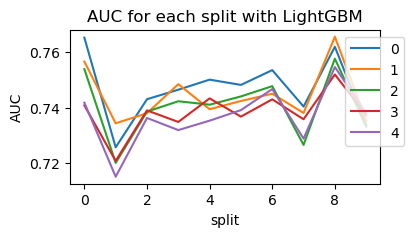

In [4]:
ModelList = p7f.get_list(file_path="../Notebook/ModelResults.pkl") 
split_results_df = pd.merge(ModelList[4][3], ModelList[4][4].rank_test_score, 
                    left_index=True, right_index=True).sort_values(by="rank_test_score").drop("rank_test_score", axis=1)
p7f.score_split_graph(split_results_df, titre=ModelList[4][1])

In [25]:
print("Lightgbm")
ModelList[4][4].sort_values(by="rank_test_score")[list(ModelList[4][4].columns[4:-3])+["mean_test_score"]][:5]

Lightgbm


,param_m__learning_rate,param_m__max_depth,param_m__min_child_samples,mean_test_score
5,0.05,3,50,0.746755
4,0.05,3,20,0.744263
7,0.05,6,50,0.740469
6,0.05,6,20,0.738337
3,0.1,6,50,0.736738


Ces graphes ne sont pas suffisant pour déterminer le meilleur model pour prédire une faillite d'un candidat.  
Une métrique $score_{final}$ est proposée pour permettre d'estimer le meilleur model:  
$\displaystyle score_{final} = score_{control} + \alpha\cdot diff_{score}+\frac{\beta}{t} $.  
Les coefficients $\alpha$ et $\beta$ ont été définis de la manière suivante :  
Les score control sont ordonnées et on ne retient que les 10 meilleurs.
Soit $\Delta$ la différence entre le $score_{control}$ max et le $score_{control}$ min, alors 
- la valeur obtenu pour le terme lié au temps d'exécution $\frac{\beta}{t}$ devait être au maximum égal à $\Delta$
- la valeur obtenue pour le terme lié à la différence de score $\alpha\cdot diff_{score}$ devait être au maximum égal à $\Delta$

Read file


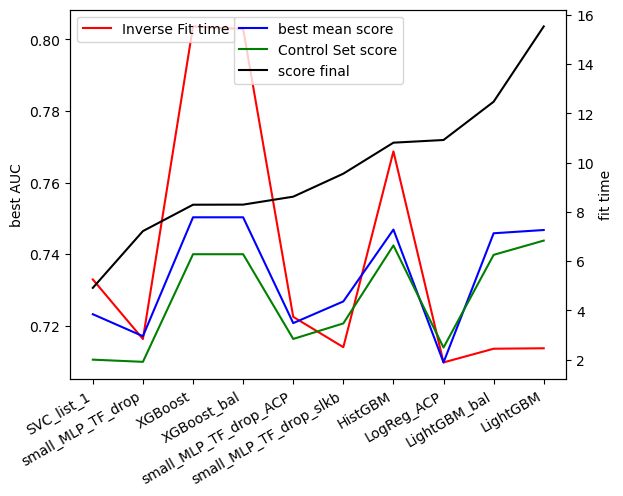

In [3]:
ModelList = p7f.get_list(file_path="../Notebook/ModelResults.pkl")
p7f.create_final_score_graph(ModelList);

**Modèle sélectionné**
Le modèle LightGBM est celui qui a obtenu le meilleur score final lors du benchmark.
Dans la suite nous nous concentrons donc sur ce modèle.

## Optimisation du modèle et correction du déséquilibre du jeu de données
Afin d'optimiser le modèle au plus proche de son utilisation final, il serait intéressant de comparer la perte du refus d'un prêt à un client viable avec  la perte subit lorsqu'un client est défaillant. Ne connaissant pas ce rapport, on part sur l'hypothèse qu'un client défaillant est 2 fois moins rentable qu'un client viable refusé (cette valeur est sûrement très sous estimée).
On choisit donc d'optimiser le $f_\beta$ score avec $\beta=2$, c'est à daire qu'on favorise le rappel 2 fois plus que la précision.

## Rééquilibrage des données
Une des problématique de ce type de sujet est que le jeu de données est déséquilibré et qu'il peut par conséquent engendrer un biais sur le modèle.  
ImbLearn est une librairie dédiée au rééquilibrage des données qui inclut différentes méthodes pour traiter ces données.
Nous tentons de corriger ce biais en utilisant différentes méthodes:
- Adasyn (Imb_learn)
- Undersampling (Imb_learn)
- TomekLinks (Imb_learn)
- NearMiss (Imb_learn)
- Smote (Imb_learn)

In [19]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Model Name" : [Model[1] for Model in ModelList][17:], 
             "Hyperparameters" : [Model[5] for Model in ModelList][17:]})

,Model Name,Hyperparameters
0,LightGBM_optim2,"{'m__max_depth': [3], 'm__learning_rate': [0.1, 0.05, 0.01], 'm__min_child_samples': [200, 100, 50], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None]}"
1,LightGBM_optim4,"{'m__max_depth': [3], 'm__learning_rate': [0.05], 'm__min_child_samples': [100], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None], 'Ad__sampling_strategy': ['minority'], 'Ad__n_neighbors': [2, 5]}"
2,LightGBM_optim3,"{'m__max_depth': [3], 'm__learning_rate': [0.05], 'm__min_child_samples': [100], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None], 'sm__sampling_strategy': [0.7, 0.3], 'sm__k_neighbors': [2, 5]}"
3,LightGBM_optim5,"{'m__max_depth': [3], 'm__learning_rate': [0.05], 'm__min_child_samples': [100], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None], 'sm__sampling_strategy': [0.3], 'sm__k_neighbors': [5]}"
4,LightGBM_optim6,"{'m__max_depth': [3], 'm__learning_rate': [0.05], 'm__min_child_samples': [100], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None], 'u__sampling_strategy': [0.1, 0.25], 'u__n_neighbors': [3, 5], 'sm__sampling_strategy': [0.3], 'sm__k_neighbors': [5]}"
5,LightGBM_optimFtwo_1,"{'m__max_depth': [3], 'm__learning_rate': [0.1, 0.05, 0.01], 'm__min_child_samples': [200, 100, 50], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None]}"
6,LightGBM_optimFtwo_2,"{'m__max_depth': [3, 5], 'm__learning_rate': [0.05], 'm__min_child_samples': [200, 300], 'm__n_estimators': [400, 600], 'm__class_weight': ['balanced', None]}"
7,LightGBM_optimFtwo_3,"{'m__max_depth': [3, 5], 'm__learning_rate': [0.05], 'm__min_child_samples': [300], 'm__n_estimators': [400], 'm__class_weight': ['balanced'], 'sm__sampling_strategy': [0.6, 0.7, 0.8], 'u__sampling_strategy': [0.5]}"
8,LightGBM_optimFtwo_2u,"{'m__max_depth': [5], 'm__learning_rate': [0.05], 'm__min_child_samples': [300], 'm__n_estimators': [400], 'm__class_weight': ['balanced', None], 'u__sampling_strategy': [0.2, 0.5]}"
9,LightGBM_optimFtwo_2ub,"{'m__max_depth': [5], 'm__learning_rate': [0.05], 'm__min_child_samples': [300], 'm__n_estimators': [400], 'm__class_weight': ['balanced'], 'u__sampling_strategy': [0.3, 0.39999999999999997, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 1.0]}"


Adasyn vs. Smote
Read file


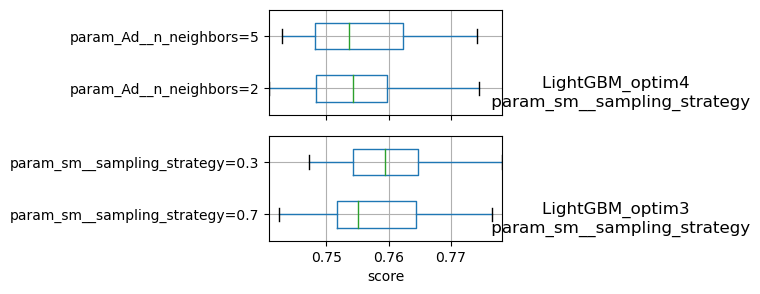

Read file


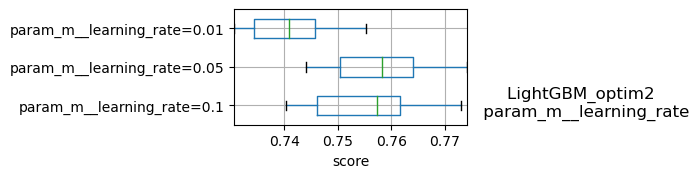

In [61]:
print("Adasyn vs. Smote")
select_in_model = ['LightGBM_optim3', 'LightGBM_optim4']
p7f.make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, 
                  param_name=["param_Ad__n_neighbors", "param_sm__sampling_strategy"], height_increasement_coeff=1.5)
select_in_model = ['LightGBM_optim2']
p7f.make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, 
                  param_name=["param_m__learning_rate"], height_increasement_coeff=1.5,
                     fixed_param={'param_m__min_child_samples': 100})

Undersampling
Read file


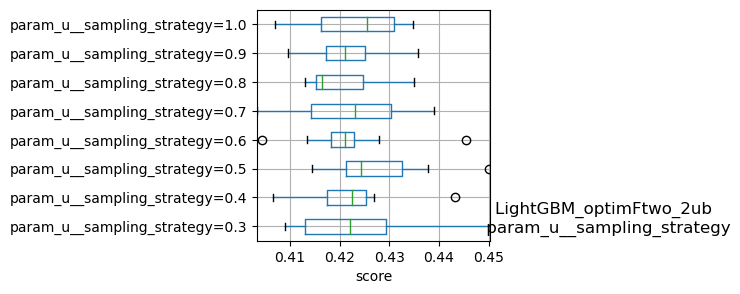

In [51]:
print("Undersampling")
select_in_model = ["LightGBM_optimFtwo_2ub"]
p7f.make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, 
                  param_name="param_u__sampling_strategy", height_increasement_coeff=3, 
                      fixed_param={"param_m__class_weight": 'balanced'})

Ci-dessus on voit que l'évolution du score avec l'undersampling effectué sur 40% du dataset n'est pas monotone.  
L'undersampling avec ratio=1 est le plus performant : le rappel est performant, mais la précision est dégradée.  

Le benchmark réalisé sur les différentes méthodes proposées par ImbLearn indique que :
- ces méthodes n'améliore pas nécessairement la performance (score), même en optimisant la méthode
- la performance de ces méthodes sont très sensible au dataset, donc l'application d'une méthode sur un sous-ensemble (avec une dstribution proche du dataset global) ne donnera pas nécessairement le même résultat que pour le dataset global.

## Optimisation du modèle et augmentation du jeu de données
L'augmentation de la taille de l'échantillon pour le training améliore le score.
Avec l'augmentation du jeu de données, on voit que :
- L'augmentation du nombre d'individus dans les feuilles tend à limiter le biais dans chaque feuille et donc améliore également le score (jusqu'à un certain point où on perd en précision), ci-dessous en passant de 300 à 500 échantillons par feuille on améliore les score.

Read file


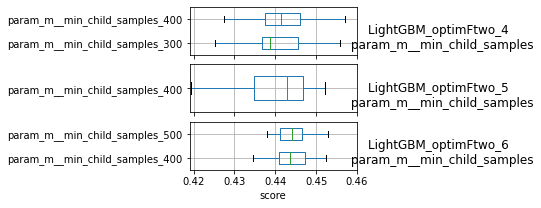

In [4]:
# 0.Date, 
# 1.name,
# 2.dataframe best_param & score moyen control et training (1 ligne), 
# 3.dataframe score/split (10 colonnes x nb parameters_set)
# 4.dataframe parameters & time & score moyen & rank (nb_parameters+time+score+rank colonnes x nb_parameters_set)
# 5.dict : liste des paramètres grid search
fixed_params={"param_m__max_depth": 5}
watched_params = ["param_m__min_child_samples"]
models_list = ['LightGBM_optimFtwo_4', "LightGBM_optimFtwo_5", 'LightGBM_optimFtwo_6']
p7f.make_synthesis_df2(models_list, fixed_params, watched_params, [0.419, 0.46])

- L'augmention de la profondeur permet de donner plus de DL au modèle, ce qui améliore le score (jusqu'à un certain point où le modèle sur-apprend). Ci-dessous, même si c'est peu flagrant, en augmentant la profondeur on améliore le modèle(calcul effectué sur 20% du dataset) 

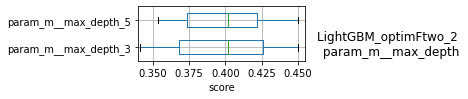

In [3]:
fixed_params={"param_m__min_child_samples": 300, }
watched_params = ["param_m__max_depth"]
models_list = ['LightGBM_optimFtwo_2']

p7f.make_synthesis_df2(models_list, fixed_params, watched_params, [0.34, 0.455])
# 'm__n_estimators': [400, 600], 'm__class_weight': ['balanced', None]}

- L'augmentation du nombre d'estimateurs tend à limiter le sur-apprentissage et donc améliore le score du modèle (jusqu'à un certain point où le modèle perd en précision), comme on peut le voir ci-dessous (apprentissage réalisé sur 40% du dataset)  

Read file


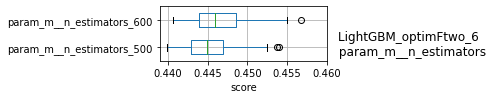

In [3]:
fixed_params={"param_m__learning_rate": 0.03}
watched_params = ["param_m__n_estimators"]
models_list = ['LightGBM_optimFtwo_6']

p7f.make_synthesis_df2(models_list, fixed_params, watched_params, [0.439, 0.46])
#m__max_depth': [5, 6], m__min_child_samples': [400, 500], param_m__n_estimators

## Optimisation finale

Finalement, après divers ajustement pas à pas, le modèle évalué le plus performant correspond au paramètres suivants:  

**Hyperparamètres**|  Valeurs
:-----------------:|:-----------:
Undersample        |  0.5
max_depth          |  8
learning_rate      |   0.02
min_child_samples  |   600
n_estimators       |   700
class_weight       |   balanced

Le $F_\beta$ score ainsi obtenu est $F_{\beta=2}=0.452$

## Critique de la méthode de maximisation employée et perspectives

**Objectif**  
L'objectif de la méthode était d'optimiser les hyperparamètres en augmentant progressivement la taille du dataset afin de dégager une tendance en fonction de la taille du dataset.
Cela fonctionne "bien" si on fait varier les hyperparamètres unitairement, et on retrouve des tendances tel qu'illustrer ci-dessus. Mais un point que je n'avais pas anticipé, est que malgré la distribution semblable des sous-dataset construit, les tendances sur les hyperparmètres d'équilibrage sont très sensibles et ne suivent pas nécessairement les mêmes tendances. Cela a un peu désorienté les recherches.

**Inconvénients d'une méthode gridsearch**  
Une méthode privilégiée pour optimiser les hyperparamètres est le gridsearch.
Le problème c'est qu'il est nécessaire d'optimiser plusieurs hyperpamètres qui n'évoluent pas de manière monotone.
Si l'on veut évaluer systématiquement les hyperparamètres sur une grille on tombe rapidement sur une limite de ressource/temps.
Par exemple supposons que l'on souhaite évaluer 10 hyperparamètres, on target 5 valeurs (ce qui est peu) pour chaque hyperparamètre. Supposons que l'apprentissage soit de l'ordre de la seconde (sur le 20% du jeu de donnée) et que  on utilse 10 splits pour la CV, cela représente 1130 jours de calcul non-stop.
Et cette estimsation est une limite très basse, puisque le temps d'apprentissage est rarement de l'ordre de la seconde.

Et avec cette méthode nous n'explorons qu'une infime partie de l'espace des solutions.
2 choix s'offrent à nous
- augmenter les ressources de calcul (malheureusement pas de budget disponible pour ce projet)
- tester une autre méthode

**Méthode alternative employée**  
La méthode employée pour minimiser le score est l'évaluation du score sur des valeurs aléatoires d'hyperparamètres.
Cette méthode est aléatoire et a été réalisé à la main:
- d'une part c'est fastidieux
- d'autre part cela manque d'efficacité

**Perspectives**  
Il serait intéressant de mettre en place une méthode plus systématique/générique pour estimer sur une large zone les valeurs de score (méthode Monte Carlo ou RandomSearch), puis restreindre au fur et à mesure les zones de recherche.
Vérifier la tendance d'un paramètre "à la main" reste intéressant mais dans ce cas il vaut mieux faire varier 1 seul paramètre (voire 2) pour avoir une vision plus claire.

Enfin il serait intéressant de regarder du côté des librairies tel que Scikit-Optimize, d'une manière plus général ce [blog](https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide) est une bonne entrée en matière.

## Features Importances/explicateur de modèle

![Shapley values](../Notebook/Shapley_Values_full.png)  
Les valeurs les plus importantes qui permettent d'expliquer le modèle sont représentées ci-dessus.
Les 3 premières features sont des données confidentiels appartenant à la banque. Les 2 premières sont clairement prépondérantes en comparaison des autres features Mais les prêts en cours, le taux de remboursement, l'âge et les autres features présentes sur le graphe influent aussi clairement sur les risques de défaillance évaluée par le modèle.

**Choix de l'explicateur de modèle**
Suite à une étude des différentes solutions proposées pour l'évaluation des features importances, le choix s'est porté sur SHAP.
Les méthodes proposées tel que la méthode features_importances disponible directement dans la librairie XGBoost ou LIME, permettent effectivement de faire ressortir l'importance de certains paramètres mais suivant certaines hypothèses qui peuvent être séduisante mais n'ont pas de fondement mathématiques et qui ne font pas concenus.
SHAP propose d'évalue l'importance d'une feature en calculant les Shapley values, c'est à dire en calculant l'impact que produit le retrait d'une feature sur le modèle en prenant en compte en compte les interractions avec les autres features (en calculant toutes les combinaisons possibles de retrait de features). C'est donc effectivement ce que l'on recherche.
Par ailleurs, SHAP est très rapide et optimisé pour les arbres de décisions tel que XGBOOST, LightGBM.
Il existe d'autres librairies mais pour le moment SHAP répond pleinement à mes exigences.

## Déploiement de la solution
Une app avec une interface utilisateur est proposé pour permettre d'évaluer le risque de défaillance d'un candidat.  
Cette app est déployée dans le cloud, l'architecture mis en place est présenté sur la figure suivante.  
![architecture_cloud](images/architecture_cloud.jpg)  
Le déploiement a été réalisé avec flask et streamlit.  
L'app est disponible sur le [lien](https://py53-projet7-dashboard-z498gi.streamlit.app/) (me contacter pour réactiver le serveur du model)

# Conclusion
La réduction du dataset en conservant une distribution proche du dataset de départ a permis de réaliser un benchmark assez large de différents modèles de classification.
L'optimisation du modèle est un sujet déclicat qui réclame de mettre en place des moyens et une méthodologie rigoureuse,
d'autant plus avec le déséquilibre des données inérant à ce type de projet.
La librairie Imblearn permet de traiter cette problématique de déséquilibre, mais permet pas de résoudre le problème qui ncessitera toujours d'aller rechercher des données supplémentaires.
Après optimisation sur l'ensemble des données, les SHAPley values permettent d'interpreter le modèle finalement
Le Déploiement d'une app permet de montrer le fonctionnement du modèle ainsi défini.